In [1]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from jupyterplot import ProgressPlot

from nn_sim.data import DataLoader, DatasetNN
from nn_sim.net import layers as nn_layers
from nn_sim.net.layers import (
    Module, Sigmoid, ReLU, IdentityActivation, 
    Step, Softmax, SSELoss, MSELoss, MAELoss, BinaryCrossEntropyLoss,
    CategoricalCrossEntropyLoss,
    Linear, HiddenLayer)

In [2]:
dataset = DatasetNN("./../datasets/iris.nnset")
print(dataset)

DatasetNN (IRIS flower dataset: Input Shape((150, 4)); Output Shape(150, 3))


In [3]:
from numpy import ndarray


class HiddenLayer(Module):

    def __init__(
        self,
        n_inputs: int,
        n_outputs: int,
        *,
        bias_active: bool,
        activation: Module,
    ) -> None:
        self.weights: np.ndarray = np.random.randn(n_inputs, n_outputs)
        self.bias_active: bool = bias_active
        self.bias = np.random.randn(n_outputs)
        if not bias_active:
            self.bias = np.zeros_like(self.bias)

        self.activation: Module = activation
        self.X = None # useful for computing gradients
        self.A = None
        self.grad_weights = np.zeros_like(self.weights)
        self.grad_bias = np.zeros_like(self.bias)

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.A_IN = x.copy() # store inputs for computing gradients
        
        x = self.activation(x @ self.weights + self.bias)
        
        self.A_OUT = x.copy() # store outputs for computing delta
        return x

    def backward(self, delta_in: np.ndarray) -> ndarray:
        # compute delta for the layer
        delta = delta_in * self.activation.backward(self.A_OUT)
        
        # compute gradients
        self.grad_weights += self.A_IN.T @ delta
        
        self.grad_bias += np.sum(delta, axis=0)
        
        # compute delta for next layers
        delta_out = delta @ self.weights.T
        return delta_out
    
    def zero_gradients(self) -> None:
        self.X = None
        self.A = None
        self.grad_weights = np.zeros_like(self.weights)
        self.bias = np.zeros_like(self.bias)


class FeedFowardNeuralNetwork(Module):
    
    def __init__(
        self,
        n_inputs: int,
        layers: list[tuple[int, bool, Module]],
    ) -> None:
        self.layers: list[HiddenLayer] = []
        
        for n_neurons, bias_active, activation in layers:
            self.layers.append(
                HiddenLayer(
                    n_inputs,
                    n_neurons,
                    bias_active=bias_active,
                    activation=activation,
                )
            )
            n_inputs = n_neurons
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            x = layer(x)
        return x
    
    def backward(self, 
                 y_pred: ndarray, 
                 y_true: np.ndarray,
                 loss_func: Module) -> ndarray:
        
        delta = loss_func.backward(y_pred, y_true)
        
        for layer in self.layers[::-1]:
            delta = layer.backward(delta)

    def zero_gradients(self):
        for layer in self.layers:
            layer.zero_gradients()    

In [4]:
net = FeedFowardNeuralNetwork(
    4, 
    [
        (2, True, Sigmoid()),
        (2, True, Sigmoid()),
        (2, True, Sigmoid()),
        (3, True, Sigmoid()),
    ]
)

y_pred = net(dataset.X)

loss_module = BinaryCrossEntropyLoss()
loss_module(y_pred, dataset.Y)

net.backward(y_pred, dataset.Y, loss_module)

## SGD

In [8]:
net = FeedFowardNeuralNetwork(
    4, # input size
    [
        (16, True, Sigmoid()),
        (16, True, Sigmoid()),
        (16, True, Sigmoid()),
        (3, True, Sigmoid()), # output layer
    ]
)

loss_func = MSELoss()
learning_rate = 0.5
MAX_EPOCHS = 2000

losses = list()

pp = ProgressPlot()

for epoch in range(MAX_EPOCHS):
    
    net.zero_gradients()
    
    y_pred = net(dataset.X)
    loss = loss_func(y_pred, dataset.Y)
    pp.update(loss)
    losses.append(loss)
    
    net.backward(y_pred, dataset.Y, loss_func)
    
    for layer in net.layers:
        layer.weights = layer.weights - learning_rate * layer.grad_weights
        layer.bias = layer.bias - learning_rate * layer.grad_bias
    
    if epoch % 100 == 0:
        learning_rate = learning_rate * 0.5

print(loss)
pp.finalize()

0.14563611259401008


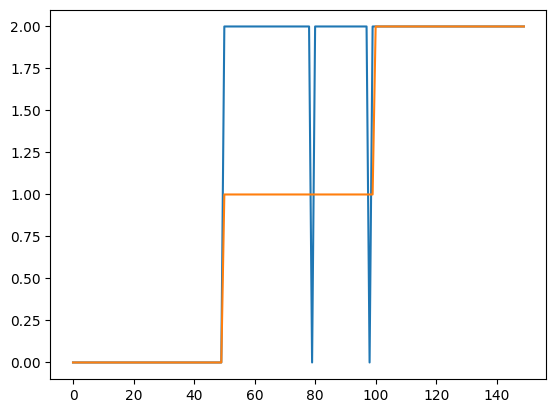

In [9]:
y_pred = net(dataset.X)
y1 = np.argmax(y_pred,axis=1)
y2 = np.argmax(dataset.Y,axis=1)
plt.plot(y1)
plt.plot(y2)
plt.show()

## SGD with Momentum

In [15]:
net = FeedFowardNeuralNetwork(
    4, # input size
    [
        (32, True, Sigmoid()),
        (64, True, Sigmoid()),
        (64, True, Sigmoid()),
        (128, True, Sigmoid()),
        (128, True, Sigmoid()),
        (128, True, Sigmoid()),
        (64, True, Sigmoid()),
        (64, True, Sigmoid()),
        (32, True, Sigmoid()),
        (3, True, Sigmoid()), # output layer
    ]
)


# Initialize momentum terms
for layer in net.layers:
    layer.velocity_weights = np.zeros_like(layer.weights)
    layer.velocity_bias = np.zeros_like(layer.bias)
    

loss_func = MSELoss()
learning_rate = 0.2
momentum = 0.9  # Common values are between 0.9 and 0.99
MAX_EPOCHS = 5000

losses = list()

pp = ProgressPlot()

for epoch in range(MAX_EPOCHS):
    
    net.zero_gradients()
    
    y_pred = net(dataset.X)
    loss = loss_func(y_pred, dataset.Y)
    pp.update(loss)
    losses.append(loss)
    
    net.backward(y_pred, dataset.Y, loss_func)
    
    for layer in net.layers:
        # Update velocities
        layer.velocity_weights = momentum * layer.velocity_weights + learning_rate * layer.grad_weights
        layer.velocity_bias = momentum * layer.velocity_bias + learning_rate * layer.grad_bias

        # Update parameters
        layer.weights = layer.weights - layer.velocity_weights
        layer.bias = layer.bias - layer.velocity_bias
    
    if epoch % 2000 == 0:
        learning_rate = learning_rate * 0.5

print(loss)
pp.finalize()

0.004371843047896


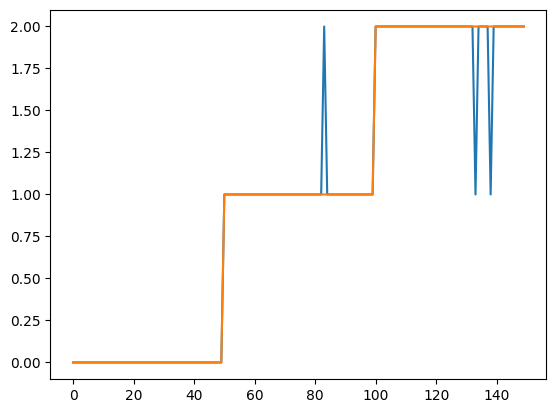

In [16]:
y_pred = net(dataset.X)
y1 = np.argmax(y_pred,axis=1)
y2 = np.argmax(dataset.Y,axis=1)
plt.plot(y1)
plt.plot(y2)
plt.show()

# adam

In [25]:
net = FeedFowardNeuralNetwork(
    4, # input size
    [
        (128, True, Sigmoid()),
        (128, True, Sigmoid()),
        (128, True, Sigmoid()),
        (128, True, Sigmoid()),
        (128, True, Sigmoid()),
        (128, True, Sigmoid()),
        (128, True, Sigmoid()),
        (128, True, Sigmoid()),
        (128, True, Sigmoid()),
        (128, True, Sigmoid()),
        (128, True, Sigmoid()),
        (128, True, Sigmoid()),
        (3, True, Sigmoid()), # output layer
    ]
)

for layer in net.layers:
    layer.m_weights = np.zeros_like(layer.weights)
    layer.v_weights = np.zeros_like(layer.weights)
    layer.m_bias = np.zeros_like(layer.bias)
    layer.v_bias = np.zeros_like(layer.bias)


beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

loss_func = MSELoss()
learning_rate = 0.001
MAX_EPOCHS = 5000

losses = list()

pp = ProgressPlot()

for epoch in range(MAX_EPOCHS):
    net.zero_gradients()
    
    y_pred = net(dataset.X)
    loss = loss_func(y_pred, dataset.Y)
    pp.update(loss)
    losses.append(loss)
    
    net.backward(y_pred, dataset.Y, loss_func)
    
    t = epoch + 1  # timestep used for bias correction
    
    for layer in net.layers:
        # Update first moment estimate
        layer.m_weights = beta1 * layer.m_weights + (1 - beta1) * layer.grad_weights
        layer.m_bias = beta1 * layer.m_bias + (1 - beta1) * layer.grad_bias
        
        # Update second moment estimate
        layer.v_weights = beta2 * layer.v_weights + (1 - beta2) * (layer.grad_weights ** 2)
        layer.v_bias = beta2 * layer.v_bias + (1 - beta2) * (layer.grad_bias ** 2)
        
        # Compute bias-corrected first and second moment estimates
        m_hat_weights = layer.m_weights / (1 - beta1 ** t)
        m_hat_bias = layer.m_bias / (1 - beta1 ** t)
        v_hat_weights = layer.v_weights / (1 - beta2 ** t)
        v_hat_bias = layer.v_bias / (1 - beta2 ** t)
        
        # Update parameters
        layer.weights -= learning_rate * m_hat_weights / (np.sqrt(v_hat_weights) + epsilon)
        layer.bias -= learning_rate * m_hat_bias / (np.sqrt(v_hat_bias) + epsilon)
    
    # Optional: Adjust learning rate here or use learning rate scheduling
    if epoch % 1000 == 0:
        learning_rate = learning_rate * 0.5
        
pp.finalize()
print(loss)

4.829628179058157e-07


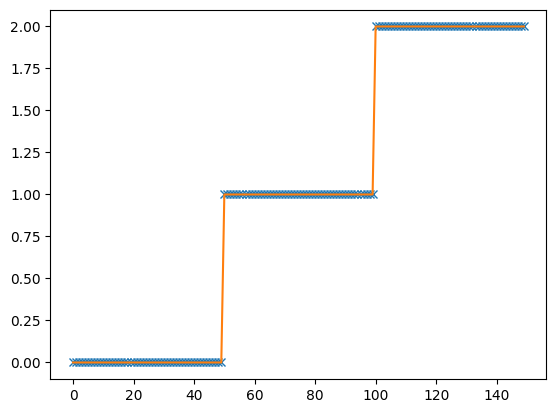

In [26]:
y_pred = net(dataset.X)
y1 = np.argmax(y_pred,axis=1)
y2 = np.argmax(dataset.Y,axis=1)
plt.plot(y1, 'x')
plt.plot(y2)
plt.show()

In [ ]:
net = FeedFowardNeuralNetwork(
    4, # input size
    [
        (32, True, Sigmoid()),
        (32, True, Sigmoid()),
        (32, True, Sigmoid()),
        (32, True, Sigmoid()),
        (16, True, Sigmoid()),
        (16, True, Sigmoid()),
        (8, True, Sigmoid()),
        (1, True, Sigmoid()), # output layer
    ]
)

for layer in net.layers:
    layer.m_weights = np.zeros_like(layer.weights)
    layer.v_weights = np.zeros_like(layer.weights)
    layer.m_bias = np.zeros_like(layer.bias)
    layer.v_bias = np.zeros_like(layer.bias)


beta1 = 0.5
beta2 = 0.999
epsilon = 1e-8

loss_func = MAELoss()
learning_rate = 0.01
MAX_EPOCHS = 10000

losses = list()

pp = ProgressPlot()

for epoch in range(MAX_EPOCHS):
    net.zero_gradients()
    
    y_pred = net(dataset.X)
    loss = loss_func(y_pred, dataset.Y[:, :1])
    pp.update(loss)
    losses.append(loss)
    
    net.backward(y_pred, dataset.Y[:, :1], loss_func)
    
    t = epoch + 1  # timestep used for bias correction
    
    for layer in net.layers:
        # Update first moment estimate
        layer.m_weights = beta1 * layer.m_weights + (1 - beta1) * layer.grad_weights
        layer.m_bias = beta1 * layer.m_bias + (1 - beta1) * layer.grad_bias
        
        # Update second moment estimate
        layer.v_weights = beta2 * layer.v_weights + (1 - beta2) * (layer.grad_weights ** 2)
        layer.v_bias = beta2 * layer.v_bias + (1 - beta2) * (layer.grad_bias ** 2)
        
        # Compute bias-corrected first and second moment estimates
        m_hat_weights = layer.m_weights / (1 - beta1 ** t)
        m_hat_bias = layer.m_bias / (1 - beta1 ** t)
        v_hat_weights = layer.v_weights / (1 - beta2 ** t)
        v_hat_bias = layer.v_bias / (1 - beta2 ** t)
        
        # Update parameters
        layer.weights -= learning_rate * m_hat_weights / (np.sqrt(v_hat_weights) + epsilon)
        layer.bias -= learning_rate * m_hat_bias / (np.sqrt(v_hat_bias) + epsilon)
    
    # Optional: Adjust learning rate here or use learning rate scheduling
    # if epoch % 1000 == 0:
    #     learning_rate = learning_rate * 0.5
        
pp.finalize()
print(loss)

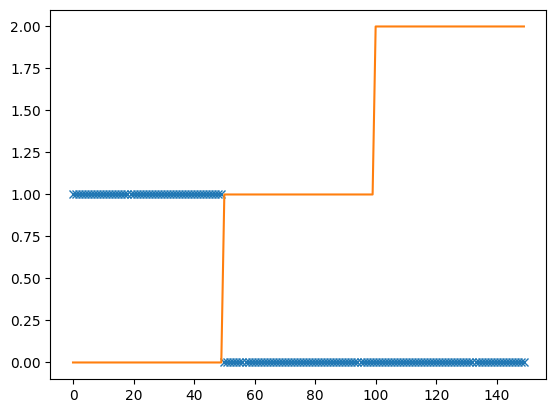

In [66]:
y_pred = net(dataset.X)
y1 = np.argmax(y_pred,axis=1)
y2 = np.argmax(dataset.Y[:,:],axis=1)
plt.plot(y_pred, 'x')
plt.plot(y2)
plt.show()